#### Oil Dataset

##### Oil Dataset with Vanilla Forest Diffusion

Class distribution before augmentation: {-1: 896, 1: 41}


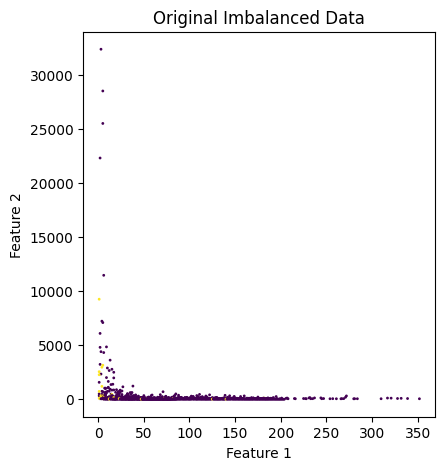

IndexError: index 49 is out of bounds for axis 1 with size 49

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score

# Step 1: Load the CSV file
#file_path = 'creditcard.csv'  # Update this path to your local CSV file
dataset='diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Separate the minority class
X_minority = X[y == 1]
# Identify integer columns
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
      # Skip column index 8
    int_indexes.append(col_index)
# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X)//50 )  # Adjust the batch size to create a balanced dataset

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)



# Step 5: Plot the generated data (first two features for visualization)
plt.subplot(1, 2, 2)
plt.scatter(X_balanced[:, 0], X_balanced[:, 1], c=y_balanced, cmap='viridis', label='Generated Data', s=1)
plt.title('Data After Generation')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 8: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recalls_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 9: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recalls_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 10: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")

In [ ]:
pd.DataFrame(X_minority_fake_adjusted).to_csv('Oil_dataset_fake.csv', index=False)

In [ ]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
def freedman_diaconis_bins(data):
    # Calculate IQR
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data) ** (1/3))
    
    # Calculate number of bins
    num_bins = int((data.max() - data.min()) / bin_width)
    
    return max(1, num_bins)  # Ensure at least 1 bin

def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Dynamically calculate number of bins for this feature
        num_bins = freedman_diaconis_bins(original_data.iloc[:, i])
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

##### Oil Dataset with Forest DIffusion & Correlation Matrix of Selected Features

Class distribution before augmentation: {-1: 896, 1: 41}


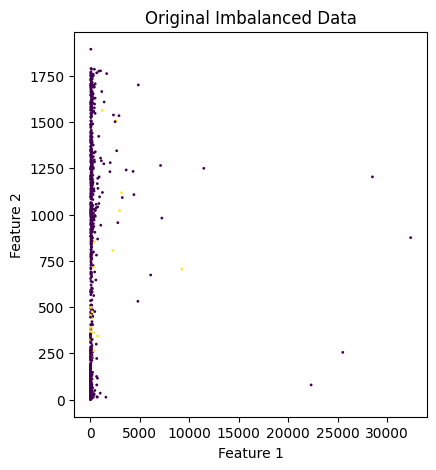

Correlation Matrix of Selected Features:
          0         1         2         3         4
0  1.000000 -0.218426 -0.107896  0.012403  0.016188
1 -0.218426  1.000000 -0.566859  0.544665 -0.119499
2 -0.107896 -0.566859  1.000000 -0.527648  0.347912
3  0.012403  0.544665 -0.527648  1.000000  0.038485
4  0.016188 -0.119499  0.347912  0.038485  1.000000


c:\Users\Tawfique\Thesis\Llama3_8B\Llama-3.1-8B-Instruct\LlamaENVpip\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Tawfique\Thesis\Llama3_8B\Llama-3.1-8B-Instruct\LlamaENVpip\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Class distribution after augmentation: {-1.0: 896, 1.0: 228}
Recall score (original data): 0.2727
Recall score (generated data): 0.8182
F1 score (original data): 0.4286
F1 score (generated data): 0.8571
Classification Report (original data):
               precision    recall  f1-score   support

          -1       0.97      1.00      0.99       271
           1       1.00      0.27      0.43        11

    accuracy                           0.97       282
   macro avg       0.99      0.64      0.71       282
weighted avg       0.97      0.97      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

          -1       0.99      1.00      0.99       271
           1       0.90      0.82      0.86        11

    accuracy                           0.99       282
   macro avg       0.95      0.91      0.93       282
weighted avg       0.99      0.99      0.99       282

Number of fake samples generated: 187


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Load your dataset (assuming X is the feature matrix and y is the target variable)
# Replace this with your data loading method
dataset='oil'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, 1:-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
# Separate the minority class
X_minority = X[y == 1]

# Step 2: Feature selection based on strongest correlation with the target
# Using SelectKBest to select top features correlated with target
selector = SelectKBest(score_func=f_classif, k=5)  # Adjust k based on the number of features to select
X_selected = selector.fit_transform(X, y)

# Get selected feature indices and names
selected_features = selector.get_support(indices=True)

# Step 3: Calculate the correlation matrix for the selected features of the minority class
X_selected_minority = X_minority[:, selected_features]
correlation_matrix = pd.DataFrame(X_selected_minority).corr()
print("Correlation Matrix of Selected Features:")
print(correlation_matrix)

# Function to make the correlation matrix positive definite if necessary
def make_positive_definite(matrix, epsilon=1e-5):
    """
    Adjusts the matrix to be positive definite by adding epsilon to the diagonal elements.
    
    Args:
        matrix (numpy.ndarray): The correlation matrix.
        epsilon (float): Small value to add to the diagonal to ensure positive definiteness.
    
    Returns:
        numpy.ndarray: Positive definite matrix.
    """
    # Check if the matrix is positive definite
    eigenvalues = np.linalg.eigvalsh(matrix)
    if np.all(eigenvalues > 0):
        return matrix
    
    # Add epsilon to the diagonal if not positive definite
    print("Adjusting matrix to be positive definite.")
    adjusted_matrix = matrix + np.eye(matrix.shape[0]) * epsilon
    
    # Re-check to confirm positive definiteness
    eigenvalues = np.linalg.eigvalsh(adjusted_matrix)
    assert np.all(eigenvalues > 0), "Failed to make the matrix positive definite."
    return adjusted_matrix

# Step 4: Ensure the correlation matrix is positive definite
positive_definite_corr_matrix = make_positive_definite(correlation_matrix.values)

# Step 5: Upsample the minority class using ForestDiffusionModel
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
    int_indexes.append(col_index)

# Assuming you have defined ForestDiffusionModel previously
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, 
                                    bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, 
                                    diffusion_type='flow', n_jobs=-1,)

# Modify the clip_extremes method in ForestDiffusionModel class
def clip_extremes(self, X):
    if self.int_indexes is not None:
        for i in self.int_indexes:
            if i < X.shape[1]:  # Check if index is within bounds
                X[:, i] = np.round(X[:, i], decimals=0)
            else:
                print(f"Warning: index {i} is out of bounds for axis 1 with size {X.shape[1]}")
    small = (X < self.X_min).astype(float)
    X = small * self.X_min + (1 - small) * X
    return X

forest_model.clip_extremes = clip_extremes.__get__(forest_model, ForestDiffusionModel)

X_minority_fake = forest_model.generate(batch_size=len(X) // 5)

# Function to adjust the correlations of the selected features in the generated data
def adjust_selected_correlation(X, target_corr_matrix, selected_features):
    """
    Adjusts the correlations of selected features in X to match the target correlation matrix.
    
    Args:
        X (numpy.ndarray): The dataset whose selected features' correlations need adjusting.
        target_corr_matrix (numpy.ndarray): The target correlation matrix for selected features.
        selected_features (list): List of indices for the selected features.
    
    Returns:
        numpy.ndarray: Dataset with adjusted correlations for the selected features.
    """
    # Extract only the selected features from X
    X_selected = X[:, selected_features]
    
    # Calculate the Cholesky decomposition of the target correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)
    
    # Center the data for selected features
    X_selected_centered = X_selected - np.mean(X_selected, axis=0)
    
    # Transform the selected features to match the target correlation structure
    X_selected_transformed = np.dot(X_selected_centered, L.T) + np.mean(X_selected, axis=0)
    
    # Replace the selected features in the original dataset with the transformed features
    X_adjusted = X.copy()
    X_adjusted[:, selected_features] = X_selected_transformed
    
    return X_adjusted

# Step 6: Adjust the synthetic data to match the correlation structure of selected features
X_minority_fake_adjusted = adjust_selected_correlation(X_minority_fake, positive_definite_corr_matrix, selected_features)

# Step 7: Add the generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 9: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 10: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 11: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 12: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake_adjusted)}")

In [ ]:
pd.DataFrame(X_minority_fake_adjusted).to_csv('Oil_dataset_fake_Selected_Feature_CM.csv', index=False)

NameError: name 'X_minority_fake_adjusted' is not defined

In [ ]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
def freedman_diaconis_bins(data):
    # Calculate IQR
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data) ** (1/3))
    
    # Calculate number of bins
    num_bins = int((data.max() - data.min()) / bin_width)
    
    return max(1, num_bins)  # Ensure at least 1 bin

def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Dynamically calculate number of bins for this feature
        num_bins = freedman_diaconis_bins(original_data.iloc[:, i])
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

#### Default of Credit Card Clients Dataset

##### Oil Dataset With Vanilla Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score

# Step 1: Load the CSV file
#file_path = 'creditcard.csv'  # Update this path to your local CSV file
file_path = '..\Datasets\Default_of_Credit_Card_Clients.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Separate the minority class
X_minority = X[y == 1]
# Identify integer columns
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
    if col_index != 8:  # Skip column index 8
        int_indexes.append(col_index)
# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, diffusion_type='flow', n_jobs=-1)
X_minority_fake = forest_model.generate(batch_size=len(X)//50 )  # Adjust the batch size to create a balanced dataset

# Add generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)



# Step 5: Plot the generated data (first two features for visualization)
plt.subplot(1, 2, 2)
plt.scatter(X_balanced[:, 0], X_balanced[:, 1], c=y_balanced, cmap='viridis', label='Generated Data', s=1)
plt.title('Data After Generation')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 8: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recalls_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 9: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recalls_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 10: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")

In [ ]:
pd.DataFrame(X_minority_fake_adjusted).to_csv('Default_of_Credit_Card_fake.csv', index=False)

In [ ]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
def freedman_diaconis_bins(data):
    # Calculate IQR
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data) ** (1/3))
    
    # Calculate number of bins
    num_bins = int((data.max() - data.min()) / bin_width)
    
    return max(1, num_bins)  # Ensure at least 1 bin

def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Dynamically calculate number of bins for this feature
        num_bins = freedman_diaconis_bins(original_data.iloc[:, i])
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

#### Oil Dataset with Forest & Selected Feature CM

Class distribution before augmentation: {0: 23364, 1: 6636}


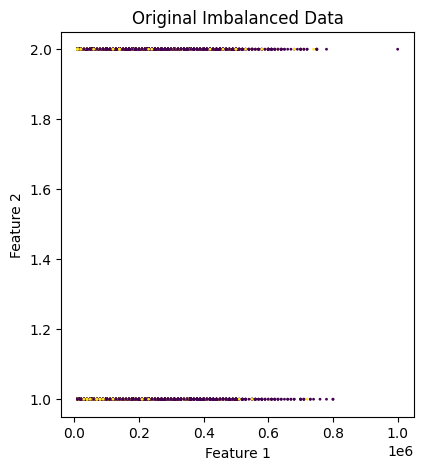

Correlation Matrix of Selected Features:
          0         1         2         3         4
0  1.000000  0.650092  0.547795  0.511548  0.480677
1  0.650092  1.000000  0.764250  0.627089  0.591104
2  0.547795  0.764250  1.000000  0.778493  0.684151
3  0.511548  0.627089  0.778493  1.000000  0.838875
4  0.480677  0.591104  0.684151  0.838875  1.000000
Class distribution after augmentation: {0.0: 23364, 1.0: 12636}
Recall score (original data): 0.3617
Recall score (generated data): 0.6658
F1 score (original data): 0.4577
F1 score (generated data): 0.7455
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.36      0.46      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000

Classification Report (generated data):
               precision    recall

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Load your dataset (assuming X is the feature matrix and y is the target variable)
# Replace this with your data loading method
file_path = '..\Datasets\Default_of_Credit_Card_Clients.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
# Separate the minority class
X_minority = X[y == 1]

# Step 2: Feature selection based on strongest correlation with the target
# Using SelectKBest to select top features correlated with target
selector = SelectKBest(score_func=f_classif, k=5)  # Adjust k based on the number of features to select
X_selected = selector.fit_transform(X, y)

# Get selected feature indices and names
selected_features = selector.get_support(indices=True)

# Step 3: Calculate the correlation matrix for the selected features of the minority class
X_selected_minority = X_minority[:, selected_features]
correlation_matrix = pd.DataFrame(X_selected_minority).corr()
print("Correlation Matrix of Selected Features:")
print(correlation_matrix)

# Function to make the correlation matrix positive definite if necessary
def make_positive_definite(matrix, epsilon=1e-5):
    """
    Adjusts the matrix to be positive definite by adding epsilon to the diagonal elements.
    
    Args:
        matrix (numpy.ndarray): The correlation matrix.
        epsilon (float): Small value to add to the diagonal to ensure positive definiteness.
    
    Returns:
        numpy.ndarray: Positive definite matrix.
    """
    # Check if the matrix is positive definite
    eigenvalues = np.linalg.eigvalsh(matrix)
    if np.all(eigenvalues > 0):
        return matrix
    
    # Add epsilon to the diagonal if not positive definite
    print("Adjusting matrix to be positive definite.")
    adjusted_matrix = matrix + np.eye(matrix.shape[0]) * epsilon
    
    # Re-check to confirm positive definiteness
    eigenvalues = np.linalg.eigvalsh(adjusted_matrix)
    assert np.all(eigenvalues > 0), "Failed to make the matrix positive definite."
    return adjusted_matrix

# Step 4: Ensure the correlation matrix is positive definite
positive_definite_corr_matrix = make_positive_definite(correlation_matrix.values)

# Step 5: Upsample the minority class using ForestDiffusionModel
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
    if col_index != 8:  # Skip column index 8
        int_indexes.append(col_index)

# Assuming you have defined ForestDiffusionModel previously
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, 
                                    bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, 
                                    diffusion_type='flow', n_jobs=-1,)

# Modify the clip_extremes method in ForestDiffusionModel class
def clip_extremes(self, X):
    if self.int_indexes is not None:
        for i in self.int_indexes:
            if i < X.shape[1]:  # Check if index is within bounds
                X[:, i] = np.round(X[:, i], decimals=0)
            else:
                print(f"Warning: index {i} is out of bounds for axis 1 with size {X.shape[1]}")
    small = (X < self.X_min).astype(float)
    X = small * self.X_min + (1 - small) * X
    return X

forest_model.clip_extremes = clip_extremes.__get__(forest_model, ForestDiffusionModel)

X_minority_fake = forest_model.generate(batch_size=len(X) // 5)

# Function to adjust the correlations of the selected features in the generated data
def adjust_selected_correlation(X, target_corr_matrix, selected_features):
    """
    Adjusts the correlations of selected features in X to match the target correlation matrix.
    
    Args:
        X (numpy.ndarray): The dataset whose selected features' correlations need adjusting.
        target_corr_matrix (numpy.ndarray): The target correlation matrix for selected features.
        selected_features (list): List of indices for the selected features.
    
    Returns:
        numpy.ndarray: Dataset with adjusted correlations for the selected features.
    """
    # Extract only the selected features from X
    X_selected = X[:, selected_features]
    
    # Calculate the Cholesky decomposition of the target correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)
    
    # Center the data for selected features
    X_selected_centered = X_selected - np.mean(X_selected, axis=0)
    
    # Transform the selected features to match the target correlation structure
    X_selected_transformed = np.dot(X_selected_centered, L.T) + np.mean(X_selected, axis=0)
    
    # Replace the selected features in the original dataset with the transformed features
    X_adjusted = X.copy()
    X_adjusted[:, selected_features] = X_selected_transformed
    
    return X_adjusted

# Step 6: Adjust the synthetic data to match the correlation structure of selected features
X_minority_fake_adjusted = adjust_selected_correlation(X_minority_fake, positive_definite_corr_matrix, selected_features)

# Step 7: Add the generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 9: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 10: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 11: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 12: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake_adjusted)}")

In [ ]:
pd.DataFrame(X_minority_fake_adjusted).to_csv('Default_of_Credit_Card_Clients_fake_Selected_Feature_CM.csv', index=False)

In [ ]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
def freedman_diaconis_bins(data):
    # Calculate IQR
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data) ** (1/3))
    
    # Calculate number of bins
    num_bins = int((data.max() - data.min()) / bin_width)
    
    return max(1, num_bins)  # Ensure at least 1 bin

def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Dynamically calculate number of bins for this feature
        num_bins = freedman_diaconis_bins(original_data.iloc[:, i])
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)

#### Chronic Kidney Disease 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Load your dataset (assuming X is the feature matrix and y is the target variable)
# Replace this with your data loading method
file_path = '..\Datasets\chronic_kidney_disease.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, 1:-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
# Separate the minority class
X_minority = X[y == 1]

# Step 2: Feature selection based on strongest correlation with the target
# Using SelectKBest to select top features correlated with target
selector = SelectKBest(score_func=f_classif, k=5)  # Adjust k based on the number of features to select
X_selected = selector.fit_transform(X, y)

# Get selected feature indices and names
selected_features = selector.get_support(indices=True)

# Step 3: Calculate the correlation matrix for the selected features of the minority class
X_selected_minority = X_minority[:, selected_features]
correlation_matrix = pd.DataFrame(X_selected_minority).corr()
print("Correlation Matrix of Selected Features:")
print(correlation_matrix)

# Function to make the correlation matrix positive definite if necessary
def make_positive_definite(matrix, epsilon=1e-5):
    """
    Adjusts the matrix to be positive definite by adding epsilon to the diagonal elements.
    
    Args:
        matrix (numpy.ndarray): The correlation matrix.
        epsilon (float): Small value to add to the diagonal to ensure positive definiteness.
    
    Returns:
        numpy.ndarray: Positive definite matrix.
    """
    # Check if the matrix is positive definite
    eigenvalues = np.linalg.eigvalsh(matrix)
    if np.all(eigenvalues > 0):
        return matrix
    
    # Add epsilon to the diagonal if not positive definite
    print("Adjusting matrix to be positive definite.")
    adjusted_matrix = matrix + np.eye(matrix.shape[0]) * epsilon
    
    # Re-check to confirm positive definiteness
    eigenvalues = np.linalg.eigvalsh(adjusted_matrix)
    assert np.all(eigenvalues > 0), "Failed to make the matrix positive definite."
    return adjusted_matrix

# Step 4: Ensure the correlation matrix is positive definite
positive_definite_corr_matrix = make_positive_definite(correlation_matrix.values)

# Step 5: Upsample the minority class using ForestDiffusionModel
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
    if col_index != 8:  # Skip column index 8
        int_indexes.append(col_index)

# Assuming you have defined ForestDiffusionModel previously
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, 
                                    bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, 
                                    diffusion_type='flow', n_jobs=-1,)

# Modify the clip_extremes method in ForestDiffusionModel class
def clip_extremes(self, X):
    if self.int_indexes is not None:
        for i in self.int_indexes:
            if i < X.shape[1]:  # Check if index is within bounds
                X[:, i] = np.round(X[:, i], decimals=0)
            else:
                print(f"Warning: index {i} is out of bounds for axis 1 with size {X.shape[1]}")
    small = (X < self.X_min).astype(float)
    X = small * self.X_min + (1 - small) * X
    return X

forest_model.clip_extremes = clip_extremes.__get__(forest_model, ForestDiffusionModel)

X_minority_fake = forest_model.generate(batch_size=len(X) // 5)

# Function to adjust the correlations of the selected features in the generated data
def adjust_selected_correlation(X, target_corr_matrix, selected_features):
    """
    Adjusts the correlations of selected features in X to match the target correlation matrix.
    
    Args:
        X (numpy.ndarray): The dataset whose selected features' correlations need adjusting.
        target_corr_matrix (numpy.ndarray): The target correlation matrix for selected features.
        selected_features (list): List of indices for the selected features.
    
    Returns:
        numpy.ndarray: Dataset with adjusted correlations for the selected features.
    """
    # Extract only the selected features from X
    X_selected = X[:, selected_features]
    
    # Calculate the Cholesky decomposition of the target correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)
    
    # Center the data for selected features
    X_selected_centered = X_selected - np.mean(X_selected, axis=0)
    
    # Transform the selected features to match the target correlation structure
    X_selected_transformed = np.dot(X_selected_centered, L.T) + np.mean(X_selected, axis=0)
    
    # Replace the selected features in the original dataset with the transformed features
    X_adjusted = X.copy()
    X_adjusted[:, selected_features] = X_selected_transformed
    
    return X_adjusted

# Step 6: Adjust the synthetic data to match the correlation structure of selected features
X_minority_fake_adjusted = adjust_selected_correlation(X_minority_fake, positive_definite_corr_matrix, selected_features)

# Step 7: Add the generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 9: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 10: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 11: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 12: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake_adjusted)}")

In [ ]:
# Apply openTSNE for t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=30, metric="euclidean",
    n_jobs=-1  # Use all available CPU cores for speedup
)

# Fit openTSNE on the PCA-reduced minority class data
X_tsne_minority = tsne.fit(X_minority)
X_tsne_res_minority = tsne.fit(X_minority_fake_adjusted)

# Create t-SNE Plot for minority class before and after SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot for original minority class data
ax.scatter(X_tsne_minority[:, 0], X_tsne_minority[:, 1], c='blue', label='Minority Class (Original)', alpha=0.6)
# Plot for SMOTE-generated synthetic minority class data
ax.scatter(X_tsne_res_minority[:, 0], X_tsne_res_minority[:, 1], c='orange', label='Minority Class (FD_CM)', alpha=0.6)

# Add labels and legends
ax.set_title('t-SNE of Minority Class (Before and After FD_CM)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
def freedman_diaconis_bins(data):
    # Calculate IQR
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    
    # Calculate bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data) ** (1/3))
    
    # Calculate number of bins
    num_bins = int((data.max() - data.min()) / bin_width)
    
    return max(1, num_bins)  # Ensure at least 1 bin

def plot_feature_distributions(original_data, synthetic_data, num_cols=2):
    num_features = original_data.shape[1]
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows

    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size dynamically

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Dynamically calculate number of bins for this feature
        num_bins = freedman_diaconis_bins(original_data.iloc[:, i])
        
        # Plot original data (blue)
        plt.hist(original_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Original', color='blue', density=True)
        
        # Plot synthetic data (red)
        plt.hist(synthetic_data.iloc[:, i], bins=num_bins, alpha=0.5, label='Synthetic', color='red', density=True)
        
        plt.title(f'Distribution of Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
X_minority_df = pd.DataFrame(X_minority)
X_minority_fake_df = pd.DataFrame(X_minority_fake_adjusted)
plot_feature_distributions(X_minority_df, X_minority_fake_df)